# Introduction

This notebook is a bit of an introduction to GANs. The goal of this notebook is to take in a photo and apply a Monet filter on to it to make it look like Monet painted it. The dataset will be from this Kaggle competition (https://www.kaggle.com/competitions/gan-getting-started).


Generative Adversarial Networks (GANs) use something called adversarial training. Adversial training is a way to kind of test the model, trying to mislead the model so it can update it and make better outputs. GANs use a generator which creates fake data and a discriminator which determines if the input (in this case an image) is real or fake. This leads to refining the generated image over time.


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import cv2

!pip install optree
from tensorflow import keras
from tensorflow.keras import layers

import shutil
import PIL



try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
    
AUTOTUNE = tf.data.experimental.AUTOTUNE



2024-04-21 21:08:29.034680: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 21:08:29.034787: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 21:08:29.145801: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Looking at the pictures and getting some dimensions - EDA

In [2]:
# Read in the data. 
monet_jpg = '/kaggle/input/gan-getting-started/monet_jpg'
photo_jpg = '/kaggle/input/gan-getting-started/photo_jpg'
monet_tf = '/kaggle/input/gan-getting-started/monet_tfrec'
photo_tf = '/kaggle/input/gan-getting-started/photo_tfrec'

# List how many photos and RFRecords there are. 
print("Monet jpg: ", len(os.listdir(monet_jpg)))
print("Photo jpg: ",len(os.listdir(photo_jpg)))
print("Monet TFRecords: ",len(os.listdir(monet_tf)))
print("Photo TFRecords: ",len(os.listdir(photo_tf)))


Monet jpg:  300
Photo jpg:  7038
Monet TFRecords:  5
Photo TFRecords:  20


There are 300 Monet photos, 7038 regular photos, 5 Monet TFRecords, and 20 photo TFRecords.

A TFRecord is a TensorFlow Record. It is a format for storing binary records. In this case it is storing our photos. 

In [3]:
# Get a list of images in the directory.
image_files = os.listdir(monet_jpg)
print("Image: ", image_files[0])
print("Path:", os.path.join(monet_jpg, image_files[0]))

# Read the first image.
image = cv2.imread(os.path.join(monet_jpg, image_files[0]))

# Print the size of the image.
print('Image size:', image.shape)

Image:  f4413e97bd.jpg
Path: /kaggle/input/gan-getting-started/monet_jpg/f4413e97bd.jpg
Image size: (256, 256, 3)


In the Kaggle competition description, it told us that the photos are 256x256x3 (RGB). We can see that from the first image as well: Image size: (256, 256, 3). 

In [4]:
IMAGE_SIZE = [256, 256]

# Scale the image. 
def normalized_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

# Function to read the TFRecord. 
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = normalized_image(example['image'])
    return image

In [5]:
# Load the dataset. 
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [6]:
# Get all of the TFRecords from Monet and photos directory. 
monet_files = tf.io.gfile.glob(str(monet_tf + '/*.tfrec'))
print('Monet TFRecord Files:', len(monet_files))

photo_files = tf.io.gfile.glob(str(photo_tf + '/*.tfrec'))
print('Photo TFRecord Files:', len(photo_files))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


Once again there are 5 Monet TFRecords and 20 photo TFRecords.

In [7]:
# Load the TFRecords. 
monet_ds = load_dataset(monet_files, labeled=True).batch(1)
photo_ds = load_dataset(photo_files, labeled=True).batch(1)
print(monet_ds)

<_BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>


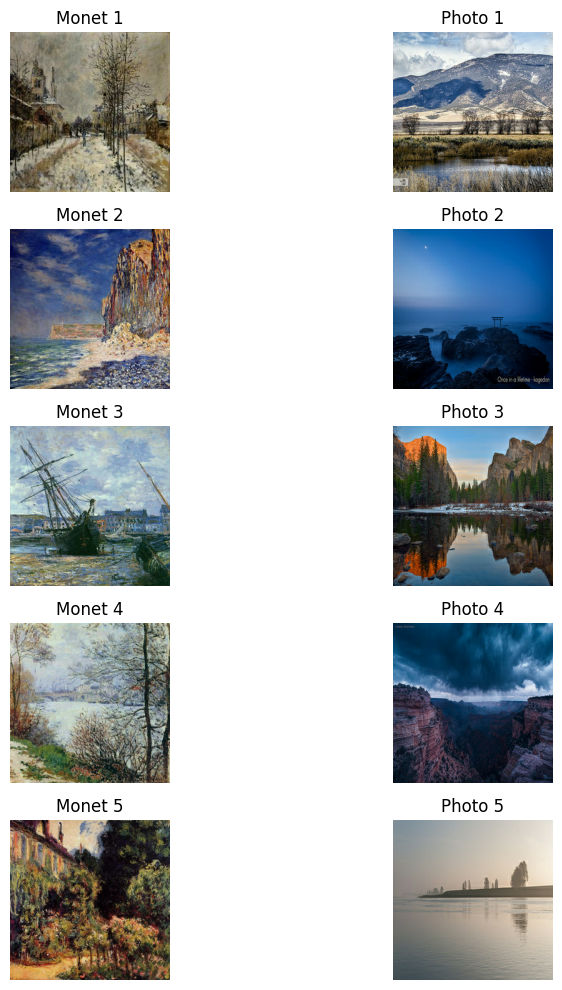

In [8]:
# Create an iterator for each dataset.
monet_iter = iter(monet_ds)
photo_iter = iter(photo_ds)

# Get 5 examples from each dataset.
example_monets = [next(monet_iter) for _ in range(5)]
example_photos = [next(photo_iter) for _ in range(5)]

plt.figure(figsize=(10, 10))

# Plot Monet paintings.
for i, example in enumerate(example_monets, start=1):
    plt.subplot(5, 2, i * 2 - 1)
    plt.title(f'Monet {i}')
    plt.imshow(example[0] * 0.5 + 0.5)
    plt.axis('off')

# Plot photos.
for i, example in enumerate(example_photos, start=1):
    plt.subplot(5, 2, i * 2)
    plt.title(f'Photo {i}')
    plt.imshow(example[0] * 0.5 + 0.5)
    plt.axis('off')

plt.tight_layout()
plt.show()


The Monet photos are painted and have more blended details than the photos. The model will have to learn this and try to create a more Monet painted look. 

# Building the model

We will be using a CycleGAN for this model. A CycleGAN is a model which trys to learn the mapping of  an input image and applys that mapping to an output image. So in this case the model will try to learn the mappings of Monet photos and apply it to the regular photos. This is done using the adversarial network where the generator will take in the photos and try to apply the Monet filter on to it. The Discriminator will try to differentiate if the generated Monet filtered photo is real or fake. 

Downsampling will reduce the dimensions of the photo and upsampling will increase the dimensions of the photo. Downsampling the photo allows more features to be extracted from the photo and upsampling will bring up those features in the generated image. 

In [9]:
OUTPUT_CHANNELS = 3

# Define a function to downsample the photo. 
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, 
                             padding='same',
                             kernel_initializer=initializer, 
                             use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

# Define a function to upsample the photo. 
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                               padding='same',
                                               kernel_initializer=initializer,
                                               use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result


The Generator will generate our new image. This will be the photo with the Monet filter on it. 

In [10]:
# Define our generator. 
def Generator():
    inputs = layers.Input(shape=[256, 256, 3])

    # Downsampling.
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    # Upsampling.
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    # Initialize the Generator weights. 
    initializer = tf.random_normal_initializer(0., 0.02)
    
    # Transpose the image. 
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsample the image.
    resid_con = []
    for down in down_stack:
        x = down(x)
        resid_con.append(x)

    resid_con = reversed(resid_con[:-1])

    # Upsample the new image and establishing the residual connections.
    for up, resid_con in zip(up_stack, resid_con):
        x = up(x)
        x = layers.Concatenate()([x, resid_con])

    # Transpose the image. 
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)



The Discriminator will determine if the generated image is fake or real. 

In [11]:
# Define the Discriminator function. 
def Discriminator():
    
    # Initialize the Discriminator weights. 
    initializer = tf.random_normal_initializer(0., 0.02)

    input_dis = layers.Input(shape=[256, 256, 3], name='input_image')

    x = input_dis

    # Downsample the image. 
    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    # Apply normalization and leaky ReLU activations.
    batchnorm1 = layers.BatchNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(batchnorm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=input_dis, outputs=last)


In [12]:
# Run the Generator and Discriminator.
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet filter paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

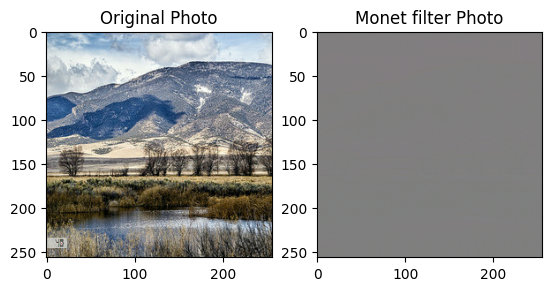

In [13]:
# Get an example photo and Monet filtered photo. 
example_photo = next(iter(photo_ds))
to_monet = monet_generator(example_photo)

# Plot the photo. 
plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

# Plot the Monet filtered photo. 
plt.subplot(1, 2, 2)
plt.title("Monet filter Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

The photo will not have a Monet filter on it yet since we have not trained the model yet.

The CycleGAN class below will run each Generator and Discriminator and calculate different gradient losses for each Epoch. This includes going from photos to Monet back to photos, Monet to photo back to monet, generating itself, checking real and fake images, and calculating the generator loss, cycle consistency loss, total generator loss, discriminator loss and gradients of the generator and discriminator. The model will use an Adam optimizer which is a stochastic gradient descent that will adapt weights as the model is training.

In [14]:
# Create the CycleGAN. 
class CycleGan(tf.keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        # Watch and run multiple gradients over the same computation. 
        with tf.GradientTape(persistent=True) as tape:
            
            # Photo to monet back to photo. 
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # Monet to photo back to monet.
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # Generating itself. 
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # Discriminator used to check, inputing real images.
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # Discriminator used to check, inputing fake images.
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # Evaluates generator loss.
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # Evaluates total cycle consistency loss.
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # Evaluates total generator loss.
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # Evaluates discriminator loss.
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator.
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer.
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }


In [15]:
# Define the loss functions.
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

with strategy.scope():
    # Define discriminator loss. 
    def discrim_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5
    
    # Define generator loss. 
    def gen_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

    # Define cycle loss. 
    def cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1
    
    # Define identity loss.
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [16]:
# Define the optimizers - Adam optimizer. 
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [17]:
# Create the model. 
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = gen_loss,
        disc_loss_fn = discrim_loss,
        cycle_loss_fn = cycle_loss,
        identity_loss_fn = identity_loss
    )

In [18]:
# Fit the model using 25 Epochs.
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

Epoch 1/25


I0000 00:00:1713733852.618697      87 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 ━━━━━━━━━━━━━━━━━━━━ 173s 200ms/step - monet_disc_loss: 0.6925 - monet_gen_loss: 5.2765 - photo_disc_loss: 0.6978 - photo_gen_loss: 5.2805 - loss: 0.0000e+00
Epoch 2/25


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


300/300 ━━━━━━━━━━━━━━━━━━━━ 62s 205ms/step - monet_disc_loss: 0.6478 - monet_gen_loss: 3.6970 - photo_disc_loss: 0.6593 - photo_gen_loss: 3.6584 - loss: 0.0000e+00
Epoch 3/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 61s 205ms/step - monet_disc_loss: 0.6436 - monet_gen_loss: 3.4635 - photo_disc_loss: 0.6493 - photo_gen_loss: 3.4600 - loss: 0.0000e+00
Epoch 4/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 61s 204ms/step - monet_disc_loss: 0.6374 - monet_gen_loss: 3.3306 - photo_disc_loss: 0.6435 - photo_gen_loss: 3.3348 - loss: 0.0000e+00
Epoch 5/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 61s 205ms/step - monet_disc_loss: 0.6315 - monet_gen_loss: 3.2088 - photo_disc_loss: 0.6378 - photo_gen_loss: 3.2225 - loss: 0.0000e+00
Epoch 6/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 61s 204ms/step - monet_disc_loss: 0.6291 - monet_gen_loss: 3.0922 - photo_disc_loss: 0.6300 - photo_gen_loss: 3.1225 - loss: 0.0000e+00
Epoch 7/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 61s 204ms/step - monet_disc_loss: 0.6269 - monet_gen_loss: 3.0242 - photo_disc_loss: 0.6246

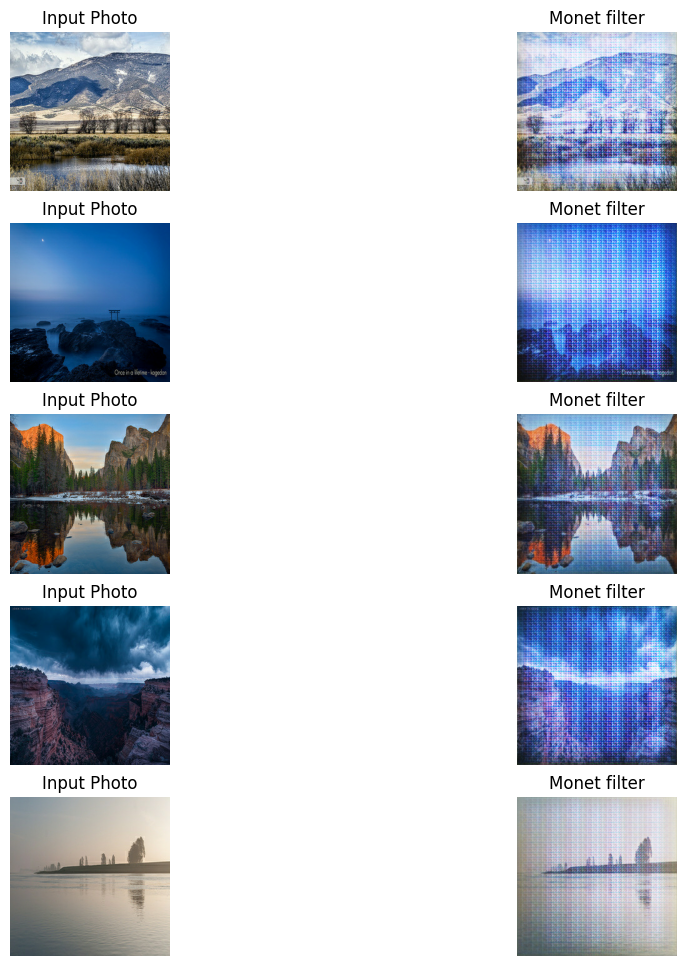

In [19]:
# For 5 photos, apply the Monet filter on the photo and print them. 
def process_and_plot_image(img, model, ax):
    pred = model(img, training=False)[0].numpy()
    pred = (pred * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[0].imshow(img)
    ax[1].imshow(pred)
    ax[0].set_title("Input Photo")
    ax[1].set_title("Monet filter")
    ax[0].axis("off")
    ax[1].axis("off")

_, axs = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    process_and_plot_image(img, monet_generator, axs[i])
plt.show()


The Monet filtered photos look a little less detailed and have a litte more of a painted look. 

In [20]:
# # Create an images directory. 
# ! mkdir ../images

# # Use the monet_generator to apply the Monet filter on all of the photos. 
# i = 1
# for img in photo_ds:
#     prediction = monet_generator(img, training=False)[0].numpy()
#     prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
#     im = PIL.Image.fromarray(prediction)
#     im.save("../images/" + str(i) + ".jpg")
#     i += 1

In [21]:
# # Zip all of the photos. 
# shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

Public Score of 141.02

# Model 2

CycleGAN but with photos rotated, flipped, and cropped. I want to see if changing the input photos would have an affect on the final score.

In [22]:
HEIGHT = 256
WIDTH = 256
HEIGHT_RESIZE = 128
WIDTH_RESIZE = 128
CHANNELS=3

# Define a function to rotate, flip, and crop images. 
def augment_image(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)

    # Perform rotations in 90 degree increments. 
    if p_rotate > .8:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .6:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .4:
        image = tf.image.rot90(image, k=1) # rotate 90º
        
    # Flip the images. 
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)
        

    # Crop images. 
    image = tf.image.random_crop(image, size=[HEIGHT_RESIZE, WIDTH_RESIZE, CHANNELS])
        
    
    return image

# Load the dataset and apply rotations, flips, and crops. 
def load_dataset_2(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(augment_image, num_parallel_calls=AUTOTUNE)  # Apply data augmentation here
    return dataset

In [23]:
# Load the TFRecords. 
monet_ds_2 = load_dataset_2(monet_files, labeled=True).batch(1)
photo_ds_2 = load_dataset_2(photo_files, labeled=True).batch(1)
print(monet_ds_2)

<_BatchDataset element_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)>


In [24]:
# Define our second generator. 
def Generator2():
    inputs = layers.Input(shape=[128, 128, 3])

    # Downsampling
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 64, 64, 64)
        downsample(128, 4),  # (batch_size, 32, 32, 128)
        downsample(256, 4),  # (batch_size, 16, 16, 256)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
    ]

    # Upsampling
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    # Initialize the Generator weights. 
    initializer = tf.random_normal_initializer(0., 0.02)
    
    # Transpose the image.
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsample the image.
    resid_con = []
    for down in down_stack:
        x = down(x)
        resid_con.append(x)

    resid_con = reversed(resid_con[:-1])

    # Upsample the new image and establishing the residual connections.
    for up, resid_con in zip(up_stack, resid_con):
        x = up(x)
        x = layers.Concatenate()([x, resid_con])

    # Transpose the image. 
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)



In [25]:
# Define the second Discriminator function. 
def Discriminator2():
    
    # Initialize the Discriminator weights. 
    initializer = tf.random_normal_initializer(0., 0.02)

    input_dis = layers.Input(shape=[128, 128, 3], name='input_image')

    x = input_dis

    # Downsample the image. 
    down1 = downsample(64, 4, False)(x)  # (batch_size, 64, 64, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 32, 32, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 16, 16, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3)  # (batch_size, 18, 18, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)  # (batch_size, 15, 15, 512)

    # Apply normalization and leaky ReLU activations.
    batchnorm1 = layers.BatchNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(batchnorm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 17, 17, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)  # (batch_size, 14, 14, 1)

    return tf.keras.Model(inputs=input_dis, outputs=last)


In [26]:
# Run the Generator and Discriminator.
with strategy.scope():
    monet_generator2 = Generator2() # transforms photos to Monet filter paintings
    photo_generator2 = Generator2() # transforms Monet paintings to be more like photos

    monet_discriminator2 = Discriminator2() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator2 = Discriminator2() # differentiates real photos and generated photos

In [27]:
# Create the second CycleGAN. 
class CycleGan2(tf.keras.Model):
    def __init__(
        self,
        monet_generator2,
        photo_generator2,
        monet_discriminator2,
        photo_discriminator2,
        lambda_cycle=10,
    ):
        super(CycleGan2, self).__init__()
        self.m_gen = monet_generator2
        self.p_gen = photo_generator2
        self.m_disc = monet_discriminator2
        self.p_disc = photo_discriminator2
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan2, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        # Watch and run multiple gradients over the same computation. 
        with tf.GradientTape(persistent=True) as tape:
            
            # Photo to monet back to photo.
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # Monet to photo back to monet.
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # Generating itself. 
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # Discriminator used to check, inputing real images.
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # Discriminator used to check, inputing fake images.
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # Evaluates generator loss.
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # Evaluates total cycle consistency loss.
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # Evaluates total generator loss.
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # Evaluates discriminator loss.
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator.
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer.
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }


In [28]:
# Define the optimizers - Adam optimizer. 
with strategy.scope():
    monet_generator_optimizer2 = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer2 = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer2 = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer2 = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [29]:
# Create the model. 
with strategy.scope():
    cycle_gan_model2 = CycleGan2(
        monet_generator2, photo_generator2, monet_discriminator2, photo_discriminator2
    )

    cycle_gan_model2.compile(
        m_gen_optimizer = monet_generator_optimizer2,
        p_gen_optimizer = photo_generator_optimizer2,
        m_disc_optimizer = monet_discriminator_optimizer2,
        p_disc_optimizer = photo_discriminator_optimizer2,
        gen_loss_fn = gen_loss,
        disc_loss_fn = discrim_loss,
        cycle_loss_fn = cycle_loss,
        identity_loss_fn = identity_loss
    )

In [30]:
# Fit the second model using 25 Epochs.
cycle_gan_model2.fit(
    tf.data.Dataset.zip((monet_ds_2, photo_ds_2)),
    epochs=25
)

Epoch 1/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 110s 121ms/step - monet_disc_loss: 0.7292 - monet_gen_loss: 5.6923 - photo_disc_loss: 0.7342 - photo_gen_loss: 5.7111 - loss: 0.0000e+00
Epoch 2/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 119ms/step - monet_disc_loss: 0.6919 - monet_gen_loss: 3.6180 - photo_disc_loss: 0.6994 - photo_gen_loss: 3.6151 - loss: 0.0000e+00
Epoch 3/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 119ms/step - monet_disc_loss: 0.6791 - monet_gen_loss: 3.3733 - photo_disc_loss: 0.6913 - photo_gen_loss: 3.3693 - loss: 0.0000e+00
Epoch 4/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 119ms/step - monet_disc_loss: 0.6759 - monet_gen_loss: 3.1485 - photo_disc_loss: 0.6869 - photo_gen_loss: 3.1461 - loss: 0.0000e+00
Epoch 5/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 119ms/step - monet_disc_loss: 0.6754 - monet_gen_loss: 2.9674 - photo_disc_loss: 0.6866 - photo_gen_loss: 2.9745 - loss: 0.0000e+00
Epoch 6/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 119ms/step - monet_disc_loss: 0.6641 - monet_gen_loss: 2.8507 - photo_disc_

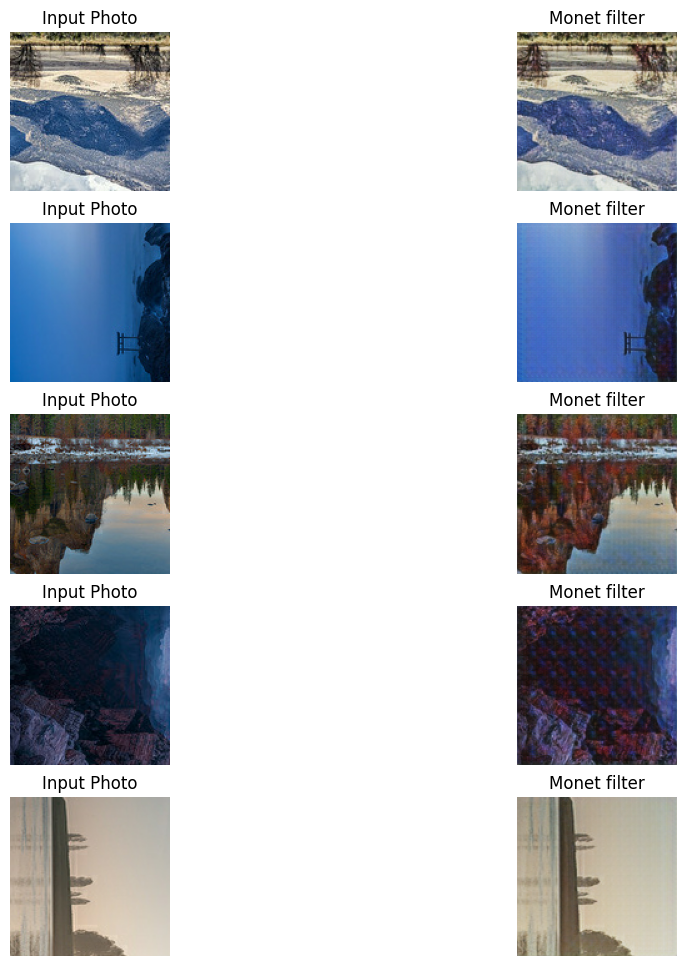

In [31]:
# For 5 photos, apply the Monet filter on the photo and print them. 
def process_and_plot_image(img, model, ax):
    pred = model(img, training=False)[0].numpy()
    pred = (pred * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[0].imshow(img)
    ax[1].imshow(pred)
    ax[0].set_title("Input Photo")
    ax[1].set_title("Monet filter")
    ax[0].axis("off")
    ax[1].axis("off")

_, axs = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds_2.take(5)):
    process_and_plot_image(img, monet_generator2, axs[i])
plt.show()


The images are a little less detailed and look a tad more of a painted look but there are these grids.

In [32]:
# Make the images directory. 
! mkdir ../images

# For the second round of photos predict the Monet filter and save them. 
i = 1
for img in photo_ds_2:
    prediction = monet_generator2(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

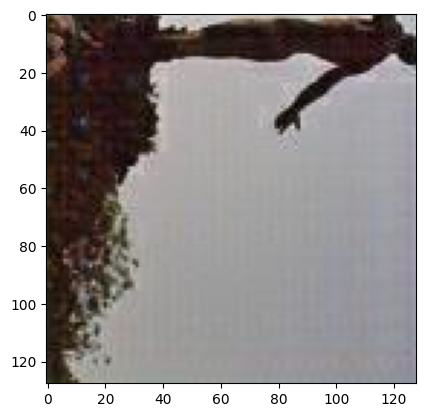

In [33]:
# Get the list of all jpg files.
MONET_FILENAMES_2 = tf.io.gfile.glob('/kaggle/images/*.jpg')
# print(MONET_FILENAMES_2)

# Read the first image file.
img = mpimg.imread(MONET_FILENAMES_2[0])

# Display the image.
plt.imshow(img)
plt.show()

The image with the Monet filter applied to the photo. 

In [34]:
# # Zip the images. 
# shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

Public score 98.40.

# Conclusion

The basic CycleGAN had a public Score of 141.02 and the same CycleGAN but with augmentation had a public score of 98.40. The CycleGAN was able to take in a photo and convert it to the style of a Monet painting. The new generated style looks like it made the photo a little less detailed. This adds a more painted style to the photo. Adding augmentation (rotations, flips, and crops) to the image improved the models performance when comparing the two final scores. 

The generated photo also has these small squares or checkerboarding within the photo. The checkerboarding is caused by the deconvolution or transposed convlution when creating the generated image. To reduce these artifacts, we could resize the convolution layers or pad the image before the convolutional layer. 

A few other things worth trying to increase the score for this project would be to use a different normalizer on the layers. Also, we could increase the number of Epochs, add more layers, or try a different optimizer. All of these things could improve the models performance. 



# References

Tensorflow and Keras

https://www.tensorflow.org/api_docs/python/tf/io/decode_jpeg
    
https://www.tensorflow.org/api_docs/python/tf/io/parse_single_example

https://www.tensorflow.org/tutorials/load_data/tfrecord

https://keras.io/examples/generative/cyclegan/

https://www.tensorflow.org/tutorials/generative/cyclegan
        
https://www.tensorflow.org/api_docs/python/tf/GradientTape

Checkerboarding

https://distill.pub/2016/deconv-checkerboard/

Kaggle

https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial

https://www.kaggle.com/code/shawncallistus9796/monet